## Ensemble Learning (Wisdom of Crowd)

Why Ensemble works can be derived from probability theory. Consider having 10 models all with accuracy > 0.5, then the probability of at least 6 correct predictions can be 
$$e_{ensemble} = \Sigma_{i=6}^{i=10} C_i^{10} \epsilon^i * (1-\epsilon)^{10-i}$$

1. Ensemble has the same bias but less variance compared to the model trained on the full dataset.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

In [5]:
# Get the data needed for model train and testing
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
df = pd.read_csv("datasets/lr_data.csv")
df = df.drop(columns="Unnamed: 0")
# df_train = df.iloc[0:1500]
# df_test = df.iloc[1500:]
df_train, df_test = split_train_test(df, 0.2)
X_train = df_train[["tmv", "demand_supply_ratio", "price", "category_grouped", "month"]]
y_train = df_train["is_booked"]
X_test = df_test[["tmv", "demand_supply_ratio", "price", "category_grouped", "month"]]
y_test = df_test["is_booked"]
print(df.shape)
print(df_train.shape)
print(df_test.shape)
df.head()

(1890, 6)
(1512, 6)
(378, 6)


,is_booked,tmv,demand_supply_ratio,price,category_grouped,month
0,0,14569,1.902318,30.0,1,5
1,1,4201,14.622831,39.0,0,5
2,1,5724,8.659708,24.0,1,4
3,1,39102,13.570390,121.0,2,12
4,0,9666,1.297453,42.0,1,8


In [9]:
# Creat and train a voting classifier in Scikit-Learn, composed of 3 classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_cls = LogisticRegression()
rf_cls = RandomForestClassifier()
svm_cls = SVC()

voting_cls = VotingClassifier(estimators=[('lr', log_cls), ('rf', rf_cls), ('svm', svm_cls)], voting='hard')

In [10]:
voting_cls.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFo...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [65]:
# Checking the prediction performance on test dataset
from sklearn.metrics import accuracy_score
for cls in (log_cls, rf_cls, svm_cls, voting_cls):
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_test)
    print(cls.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 1.0
RandomForestClassifier 0.6931216931216931
SVC 0.7063492063492064
VotingClassifier 0.746031746031746


TypeError: Input z must be a 2D array.

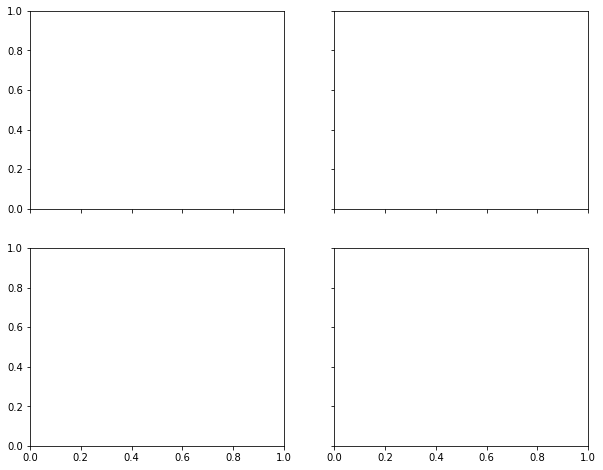

In [83]:
from itertools import product

# Loading some example data
X = X_train
y = y_train


log_cls.fit(X, y)
rf_cls.fit(X, y)
svm_cls.fit(X, y)
voting_cls.fit(X, y)

# Plotting decision regions
x_min, x_max = min(X['demand_supply_ratio']) - 1, max(X['demand_supply_ratio']) + 1
y_min, y_max = min(X['price']) - 1, max(X['price']) + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [log_cls, rf_cls, svm_cls, voting_cls],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

Looking at the above results, I want to see the underlying structure of the data and why Logistic Regression is working so well but other's not.

For this I will conduct a PCA and see how the data is distributed in 2 principal components

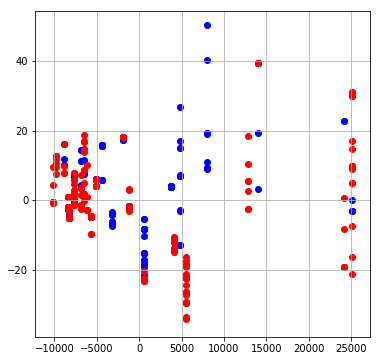

In [66]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
x2d = pca.fit_transform(X_test)
x2d_df = pd.DataFrame(x2d)
x2d_df.columns = ['pc1', 'pc2', 'pc3']
# get index for list elements 1 and 0
l0 = [i for i in range(len(y_test)) if y_test[i]==0]
X_test0 = x2d_df.iloc[l0]

l1 = [i for i in range(len(y_test)) if y_test[i]==1]
X_test1 = x2d_df.iloc[l1]

plt.figure(figsize=(6, 6))
plt.scatter(X_test0.pc1, X_test0.pc2, c='b')
plt.scatter(X_test1.pc1, X_test1.pc2, c='r')
plt.grid()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22a062e8>,
      dtype=object)

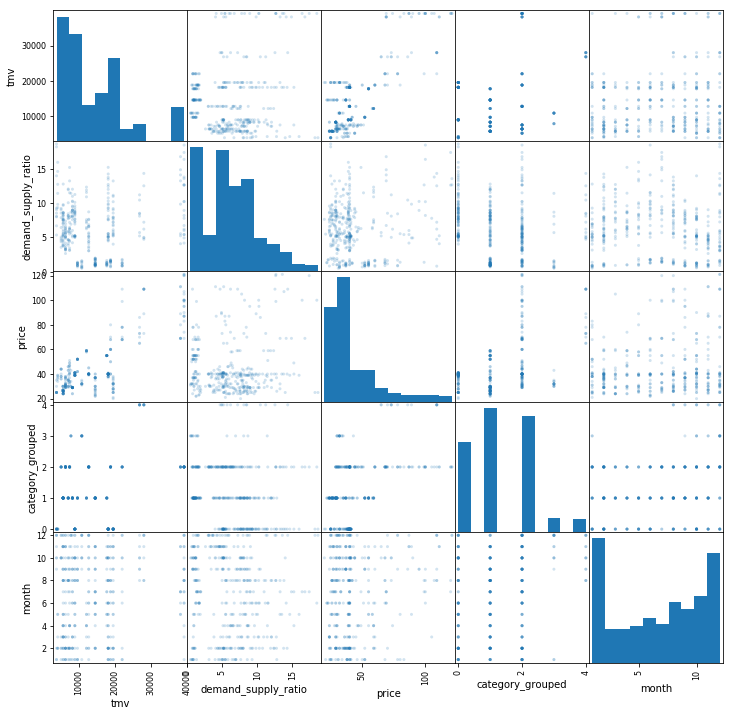

In [67]:
pd.plotting.scatter_matrix(X_test, alpha=0.2, figsize=(12, 12))

## Bagging and Pasting
Another alternative to using a different calssifier is to have a single classifier but train this on a different subsets of training data:

1. In bagging we sample with replacement from the available dataset. Sampling without replacement is called **Pasting**
2. Only about 63% of data set in bagging is used in training
3. The remaining 37% is out-of-bag samples that are not used for training. The 37% is not same for all predictors.
4. The aggregating function can be a **mode**

## Random Forest
1. Sampling both training instances and the features is called **Random Patch**, and sampling only the features is called **Random Subspaces**.
2. RF is an ensemble of decision trees with max_samples = number of training instances, selected using bootstrapping
3. Randomness is growing tree is introduced by selecting features at random for each predictors

In [96]:
for num_trees in range(496, 501):
    for num_leaf in range(8,11):
        rf_cls = RandomForestClassifier(n_estimators=500, max_leaf_nodes=5, n_jobs=-1)
        rf_cls.fit(X_train, y_train)
        y_pred_rf = rf_cls.predict(X_test)
        print("num_trees: {0}, num_leaf: {1}, accuracy: {2}".format(num_trees, num_leaf,accuracy_score(y_test, y_pred_rf)))

num_trees: 496, num_leaf: 8, accuracy: 0.7857142857142857
num_trees: 496, num_leaf: 9, accuracy: 0.7857142857142857
num_trees: 496, num_leaf: 10, accuracy: 0.7883597883597884
num_trees: 497, num_leaf: 8, accuracy: 0.791005291005291
num_trees: 497, num_leaf: 9, accuracy: 0.7883597883597884
num_trees: 497, num_leaf: 10, accuracy: 0.7936507936507936
num_trees: 498, num_leaf: 8, accuracy: 0.7857142857142857
num_trees: 498, num_leaf: 9, accuracy: 0.7804232804232805
num_trees: 498, num_leaf: 10, accuracy: 0.7777777777777778
num_trees: 499, num_leaf: 8, accuracy: 0.7857142857142857
num_trees: 499, num_leaf: 9, accuracy: 0.791005291005291
num_trees: 499, num_leaf: 10, accuracy: 0.791005291005291
num_trees: 500, num_leaf: 8, accuracy: 0.7883597883597884
num_trees: 500, num_leaf: 9, accuracy: 0.798941798941799
num_trees: 500, num_leaf: 10, accuracy: 0.783068783068783


## Feature Importance
RF makes it easy to measure feature importance by looking at how much the tree nodes that use the reatures reduces the impuriy.

In [99]:
for i, feature in enumerate(X_test.columns):
    print(feature, ": ", rf_cls.feature_importances_[i])

tmv :  0.2908507053311016
demand_supply_ratio :  0.36889364323650387
price :  0.2590480290514329
category_grouped :  0.025986991813811443
month :  0.05522063056715037


## Boosting

The idea is to train predictions sequentially, each trying to correct its predecessors.

#### AdaBoost

#### Gradient Boosting